Cohorte d'évaluation: 2018Q3, n=12,510


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3
2017Q1,1.00,0.70,0.65,0.66,0.68,0.64,0.63
2017Q2,0.70,1.00,0.96,0.92,0.93,0.89,0.88
2017Q3,0.65,0.96,1.00,0.95,0.96,0.93,0.92
2017Q4,0.66,0.92,0.95,1.00,0.98,0.98,0.97
2018Q1,0.68,0.93,0.96,0.98,1.00,0.96,0.95
2018Q2,0.64,0.89,0.93,0.98,0.96,1.00,0.99
2018Q3,0.63,0.88,0.92,0.97,0.95,0.99,1.00


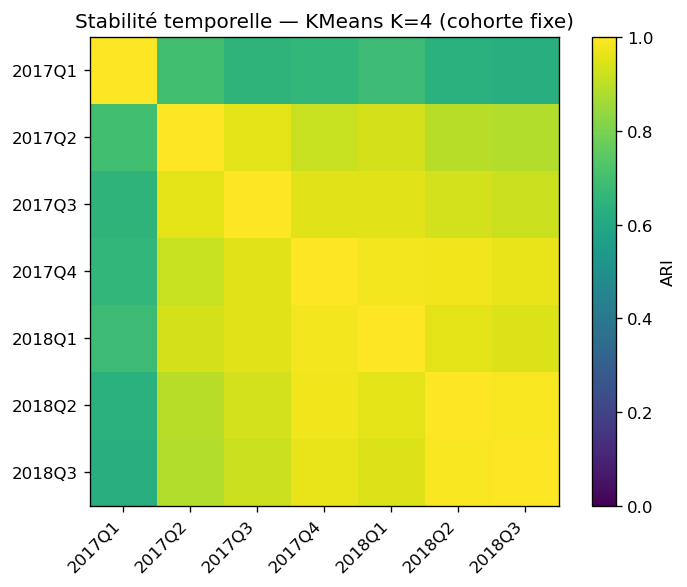

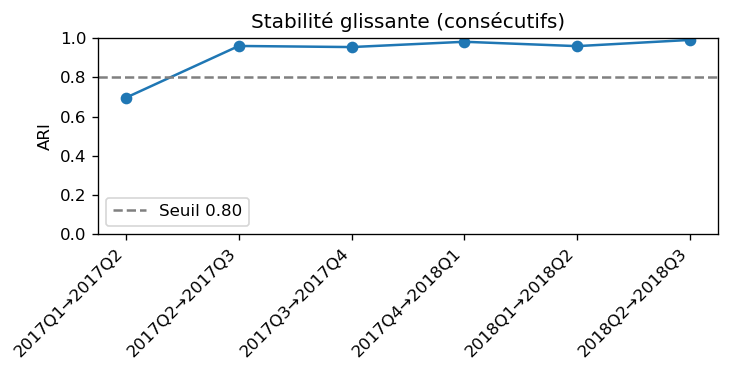

⚠️  ARI < 0.80 détecté : ré-entraîner autour de →
  - 2017Q1 → 2017Q2 : ARI=0.70


In [1]:
import os, sqlite3, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ARI
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120
os.makedirs("outputs/ari", exist_ok=True)

# =========================================
# 1) Charger/Composer la table 'feat'
#    (RFM + AOV + review + delay + dates)
# =========================================
# a) Tente de lire un export existant (si tu l’as déjà sauvé)
feat_path = "outputs/feat_rfm_plus.csv"
if os.path.exists(feat_path):
    feat = pd.read_csv(feat_path, parse_dates=["last_order_date"])
else:
    # b) Sinon, on le construit depuis SQLite (adapte si besoin)
    conn = sqlite3.connect("olist.db")

    orders_t, items_t, reviews_t = "orders", "order_items", "order_reviews"
    order_id_col, customer_id_col = "order_id", "customer_id"
    order_status_col = "order_status"
    purchase_ts_col = "order_purchase_timestamp"
    delivered_date_col, eta_date_col = "order_delivered_customer_date", "order_estimated_delivery_date"
    price_col, review_score_col = "price", "review_score"

    ref_date = pd.read_sql_query(
        f"SELECT MAX({purchase_ts_col}) AS max_date FROM {orders_t};", conn
    )["max_date"].iloc[0]

    sql = f"""
    WITH base AS (
      SELECT 
        o.{customer_id_col} AS customer_id,
        o.{order_id_col}    AS order_id,
        DATE(o.{purchase_ts_col}) AS purchase_date,
        SUM(oi.{price_col}) AS order_revenue,
        CAST(julianday(o.{delivered_date_col}) - julianday(o.{eta_date_col}) AS INT) AS delay_days
      FROM {orders_t} o
      JOIN {items_t}  oi ON oi.{order_id_col} = o.{order_id_col}
      WHERE o.{order_status_col} = 'delivered'
      GROUP BY 1,2
    ),
    by_client AS (
      SELECT
        customer_id,
        MIN(purchase_date) AS first_order_date,
        MAX(purchase_date) AS last_order_date,
        COUNT(DISTINCT order_id) AS frequency,
        ROUND(SUM(order_revenue),2) AS monetary,
        ROUND(AVG(CASE WHEN delay_days>=3 THEN 1.0 ELSE 0.0 END),3) AS delay_rate_ge3d
      FROM base
      GROUP BY 1
    ),
    reviews AS (
      SELECT o.{customer_id_col} AS customer_id,
             ROUND(AVG(r.{review_score_col}),3) AS avg_review_score
      FROM {reviews_t} r
      JOIN {orders_t} o ON o.{order_id_col} = r.{order_id_col}
      WHERE o.{order_status_col}='delivered'
      GROUP BY 1
    )
    SELECT 
      b.customer_id,
      CAST(julianday('{ref_date}') - julianday(b.last_order_date) AS INT) AS recency_days,
      b.frequency,
      b.monetary,
      ROUND(CASE WHEN b.frequency>0 THEN b.monetary*1.0/b.frequency ELSE NULL END, 2) AS aov,
      COALESCE(r.avg_review_score, 0.0) AS avg_review_score,
      COALESCE(b.delay_rate_ge3d, 0.0) AS delay_rate_ge3d,
      b.last_order_date
    FROM by_client b
    LEFT JOIN reviews r USING(customer_id);
    """
    feat = pd.read_sql_query(sql, conn, parse_dates=["last_order_date"])
    conn.close()

# Nettoyage minimal
feat = feat.fillna({"avg_review_score":0.0, "delay_rate_ge3d":0.0})
feat = feat[feat["frequency"]>0].reset_index(drop=True)

# (option) sauver pour réutilisation
feat.to_csv("outputs/feat_rfm_plus.csv", index=False)

# ==================================
# 2) Features, scaling, périodes
# ==================================
cols = ["recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"]
feat = feat.dropna(subset=cols + ["last_order_date"]).copy()
feat["last_order_date"] = pd.to_datetime(feat["last_order_date"])
feat["quarter"] = feat["last_order_date"].dt.to_period("Q")

scaler = StandardScaler().fit(feat[cols].values)  # même échelle pour toutes périodes

# Garder les trimestres avec assez de clients pour entraîner
min_train = 1500
quarters = [q for q, n in feat["quarter"].value_counts().sort_index().items() if n >= min_train]
quarters = list(quarters)
assert len(quarters) >= 3, "Pas assez de trimestres avec volume suffisant."

# Cohorte d'évaluation = dernier trimestre
eval_q = quarters[-1]
mask_eval = feat["quarter"] == eval_q
X_eval = scaler.transform(feat.loc[mask_eval, cols].values)
print(f"Cohorte d'évaluation: {eval_q}, n={X_eval.shape[0]:,}")

# ==================================
# 3) Un KMeans(K=4) par trimestre
#    + prédictions sur la cohorte fixe
# ==================================
k = 4
preds_on_eval = {}  # quarter -> labels on eval cohort
for q in quarters:
    X_train = scaler.transform(feat.loc[feat["quarter"]==q, cols].values)
    km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=42).fit(X_train)
    preds_on_eval[q] = km.predict(X_eval)

# ==================================
# 4) Matrice ARI + courbe consécutive
# ==================================
Q = len(quarters)
ari_mat = np.zeros((Q, Q))
for i, qi in enumerate(quarters):
    for j, qj in enumerate(quarters):
        ari_mat[i, j] = ARI(preds_on_eval[qi], preds_on_eval[qj])

ari_df = pd.DataFrame(ari_mat, index=[str(q) for q in quarters], columns=[str(q) for q in quarters])
display(ari_df.style.background_gradient(cmap="viridis").format("{:.2f}"))
ari_df.to_csv("outputs/ari/ari_matrix_k4.csv")

plt.figure(figsize=(6.4,5))
plt.imshow(ari_mat, cmap="viridis", vmin=0, vmax=1)
plt.xticks(range(Q), [str(q) for q in quarters], rotation=45, ha="right")
plt.yticks(range(Q), [str(q) for q in quarters])
plt.colorbar(label="ARI")
plt.title("Stabilité temporelle — KMeans K=4 (cohorte fixe)")
plt.tight_layout(); plt.savefig("outputs/ari/heatmap_ari_k4.png", dpi=150); plt.show()

# ARI entre trimestres consécutifs
ari_seq = [ARI(preds_on_eval[quarters[i]], preds_on_eval[quarters[i+1]]) for i in range(Q-1)]
plt.figure(figsize=(6.2,3.2))
plt.plot(range(1, Q), ari_seq, marker="o")
plt.xticks(range(1, Q), [f"{quarters[i]}→{quarters[i+1]}" for i in range(Q-1)], rotation=45, ha="right")
plt.ylim(0,1); plt.ylabel("ARI"); plt.title("Stabilité glissante (consécutifs)")
plt.axhline(0.80, ls="--", color="gray", label="Seuil 0.80")
plt.legend(loc="lower left")
plt.tight_layout(); plt.savefig("outputs/ari/ari_seq_k4.png", dpi=150); plt.show()

# ==================================
# 5) Reco ré-entraînement (simple)
# ==================================
threshold = 0.80
bad = [(quarters[i], quarters[i+1], s) for i, s in enumerate(ari_seq) if s < threshold]
if bad:
    print(f"⚠️  ARI < {threshold:.2f} détecté : ré-entraîner autour de →")
    for a,b,s in bad:
        print(f"  - {a} → {b} : ARI={s:.2f}")
else:
    print(f"✅ Stabilité OK : aucun ARI consécutif < {threshold:.2f}.")

#1 (petite matrice en haut) = ARI pair-à-pair entre modèles entraînés sur chaque trimestre 2017Q1…2018Q3.

Diagonale = 1.00 (même partition vs elle-même).

Hors diagonale, on voit un ARI élevé (≈0.85–0.99) entre trimestres proches, et un ARI plus bas (≈0.63–0.70) quand on compare 2017Q1 à des trimestres fin 2018 → drift “lent” dans le temps (normal).

#2 (grande heatmap) = stabilité temporelle avec cohorte fixe (même logique que ci-dessus, plus lisible).

Les blocs proches de la diagonale sont très jaunes → stabilité forte d’un trimestre à l’autre.

Les comparaisons très éloignées dans le temps deviennent un peu plus vertes → segments qui évoluent (mix produits/saisonnalité, etc.).

#3 (courbe “stabilité glissante”) = ARI entre trimestres consécutifs.

Tu es > 0.80 presque partout, souvent ~0.90–0.95 → excellente stabilité d’une période à la suivante.

Le seuil 0.80 est une règle pratique : au-dessus = stable, en-dessous = re-vérifier (features, K, data quality).

-----------------------------------------------------------------------

“Nos segments K-Means (K=4) sont stables d’un trimestre à l’autre (ARI ~0.9). Un drift lent apparaît sur 12–18 mois, ce qui est attendu.”

Conséquence opérationnelle : “Un ré-entraînement trimestriel suffit. On déclenche une revue si l’ARI consécutif < 0.80.”

-----------------------------------------------------------------------

Pourquoi il y a un léger drift sur 1–2 ans ?

Saisonnalité (Q4 / pics promo) qui modifie R, F, AOV.

Changements d’offre & mix vendeurs (impacte monetary / AOV).

Évolution du delay_rate / reviews (logistique / qualité).

In [2]:
# === ARI — VISUELS MARKETING (DataFrame OU ndarray) ===
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "outputs/marketing"
os.makedirs(OUTDIR, exist_ok=True)

def _to_df(ari, periods=None):
    """
    Convertit ari (DataFrame ou ndarray) en DataFrame carré avec index/colonnes = periods.
    - Si ari est déjà un DataFrame: on le retourne.
    - Si ari est un ndarray: il faut des 'periods' (sinon on met 0..n-1).
    """
    if isinstance(ari, pd.DataFrame):
        return ari
    ari = np.asarray(ari)
    n, m = ari.shape
    assert n == m, "La matrice ARI doit être carrée."
    if periods is None:
        periods = [f"P{i+1}" for i in range(n)]
    assert len(periods) == n, "La longueur de 'periods' doit matcher la taille de la matrice."
    return pd.DataFrame(ari, index=periods, columns=periods)

def plot_ari_heatmap_marketing(ari, periods=None,
                               title="Stabilité temporelle — KMeans K=4 (cohorte fixe)",
                               cmap="viridis",
                               fname="ARI_heatmap_marketing.png"):
    df = _to_df(ari, periods)
    periods = list(df.index)
    A = df.loc[periods, periods].values

    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(A, cmap=cmap, vmin=0, vmax=1, aspect="auto", interpolation="nearest")
    ax.set_xticks(range(len(periods))); ax.set_yticks(range(len(periods)))
    ax.set_xticklabels(periods, rotation=45, ha="right"); ax.set_yticklabels(periods)

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            txt = f"{A[i,j]:.2f}"
            ax.text(j, i, txt, ha="center", va="center",
                    fontsize=8, color=("white" if A[i,j] < 0.6 else "black"))

    cbar = fig.colorbar(im, ax=ax); cbar.set_label("ARI")
    ax.set_title(title); plt.tight_layout()
    path = os.path.join(OUTDIR, fname); plt.savefig(path, dpi=150); plt.show()
    print(f"Saved -> {path}")

def plot_ari_consecutive_trend(ari, periods=None, threshold=0.80,
                               title="Stabilité glissante (consécutifs)",
                               fname="ARI_trend_marketing.png"):
    df = _to_df(ari, periods)
    periods = list(df.index)

    consec, labels = [], []
    for i in range(len(periods)-1):
        p, pnext = periods[i], periods[i+1]
        consec.append(float(df.loc[p, pnext])); labels.append(f"{p}→{pnext}")

    x = np.arange(len(consec))
    fig, ax = plt.subplots(figsize=(7.5,3.2))
    ax.plot(x, consec, marker="o")
    ax.axhline(threshold, color="gray", ls="--", lw=1)
    ax.text(0.02, threshold+0.015, f"Seuil {threshold:.2f}", color="gray", fontsize=9)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylim(0, 1.02); ax.set_ylabel("ARI"); ax.set_xlabel("Périodes consécutives")
    for i, v in enumerate(consec):
        ax.annotate(f"{v:.2f}", (i, v), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
    ax.set_title(title); plt.tight_layout()
    path = os.path.join(OUTDIR, fname); plt.savefig(path, dpi=150); plt.show()
    print(f"Saved -> {path}")

def plot_executive_takeaway(ari, periods=None, model_name="KMeans K=4",
                            fname="ARI_executive_takeaways.png"):
    df = _to_df(ari, periods)
    periods = list(df.index)
    consec_vals = [float(df.iloc[i, i+1]) for i in range(len(periods)-1)]
    mean_consec = np.mean(consec_vals) if consec_vals else np.nan
    min_consec  = np.min(consec_vals) if consec_vals else np.nan
    last_consec = consec_vals[-1]      if consec_vals else np.nan

    msgs = [
        f"🔎 ARI (0–1) = stabilité des segments entre périodes.",
        f"📈 ARI consécutif moyen: {mean_consec:.2f} (seuil ≈ 0.80).",
        f"✅ Dernier ARI consécutif: {last_consec:.2f}.",
        f"⚠️ Si ARI < 0.80 sur 2 trimestres: re-train du modèle.",
        f"📆 Suivi recommandé: trimestriel (rolling).",
    ]
    fig, ax = plt.subplots(figsize=(9,3.6))
    ax.axis("off")
    y = 0.9; ax.text(0.02, y, f"Stabilité des segments — {model_name}", fontsize=14, weight="bold"); y -= 0.12
    for m in msgs:
        ax.text(0.04, y, m, fontsize=11); y -= 0.12
    ax.add_patch(plt.Rectangle((0.0, 0.0), 1.0, 0.04, color="#3452eb", transform=ax.transAxes, clip_on=False))
    plt.tight_layout()
    path = os.path.join(OUTDIR, fname); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show()
    print(f"Saved -> {path}")

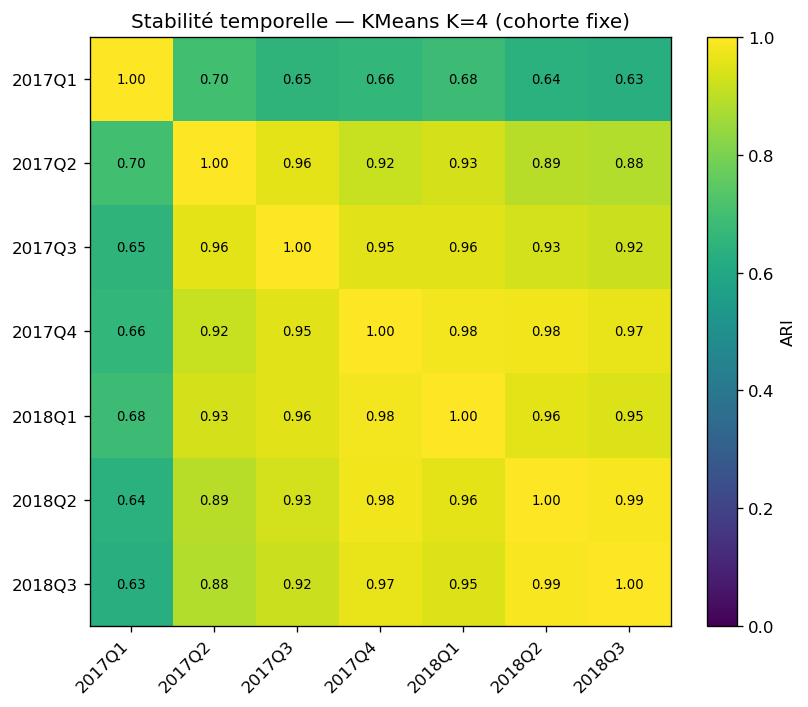

Saved -> outputs/marketing/ARI_heatmap_marketing.png


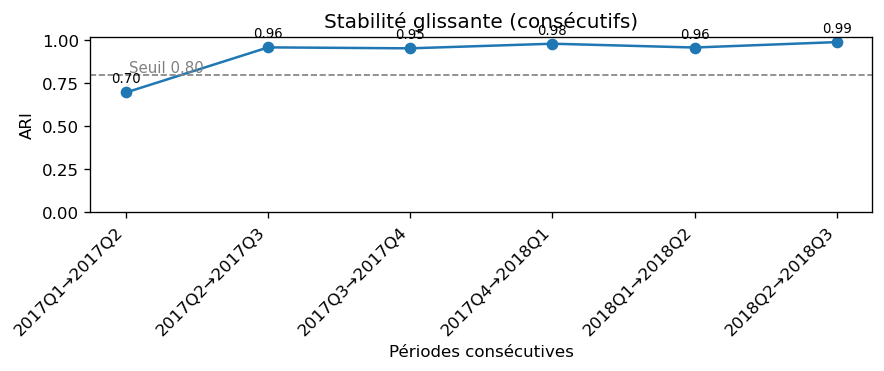

Saved -> outputs/marketing/ARI_trend_marketing.png


/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:95: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  path = os.path.join(OUTDIR, fname); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show()
/tmp/ipykernel_1040/3568685288.py:95: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  path = os.path.join(OUTDIR, fname); plt.savefig(path, dpi=150, bbox_inches="tight

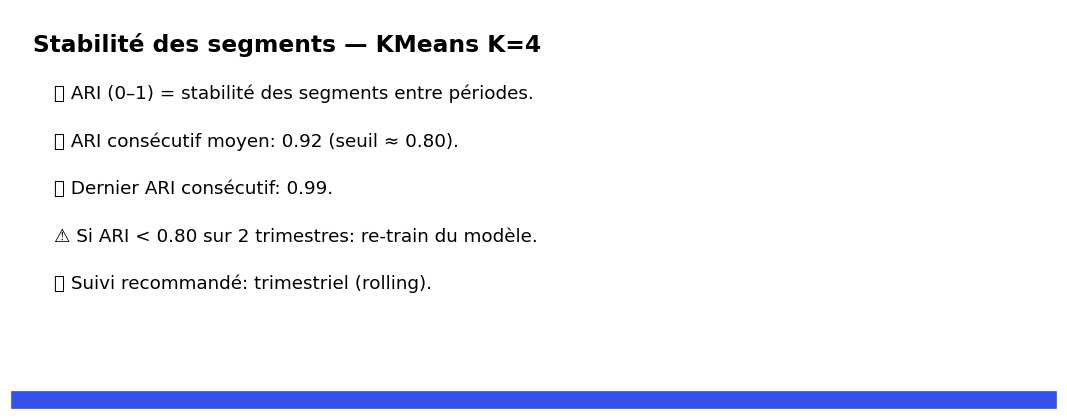

Saved -> outputs/marketing/ARI_executive_takeaways.png


In [3]:
periods = ["2017Q1","2017Q2","2017Q3","2017Q4","2018Q1","2018Q2","2018Q3"]  # adapte à ton cas
plot_ari_heatmap_marketing(ari_mat, periods=periods)
plot_ari_consecutive_trend(ari_mat, periods=periods, threshold=0.80)
plot_executive_takeaway(ari_mat, periods=periods, model_name="KMeans K=4")

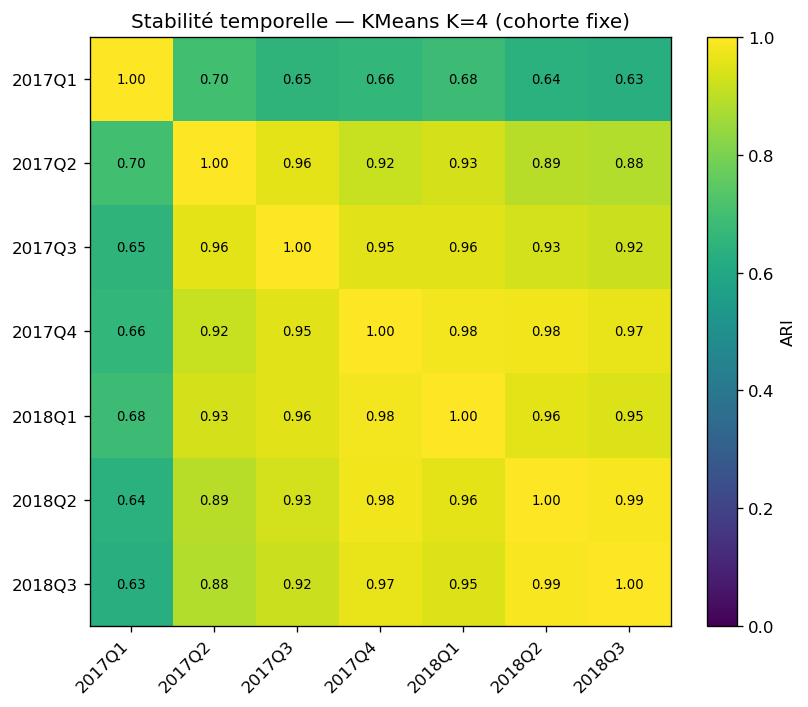

Saved -> outputs/marketing/ARI_heatmap_marketing.png


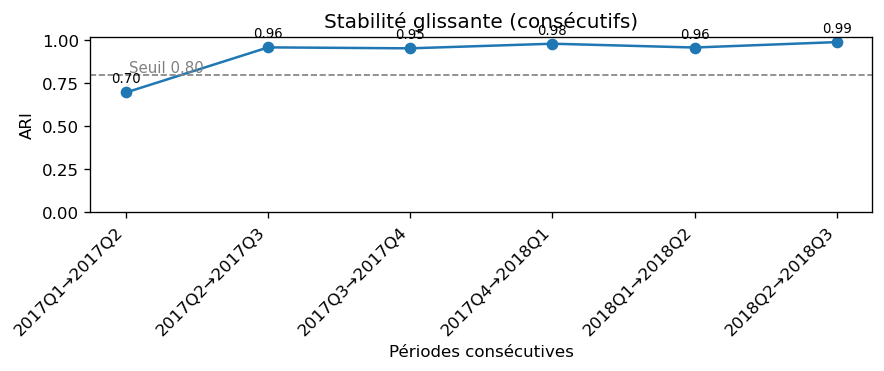

Saved -> outputs/marketing/ARI_trend_marketing.png


/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:94: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1040/3568685288.py:95: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  path = os.path.join(OUTDIR, fname); plt.savefig(path, dpi=150, bbox_inches="tight"); plt.show()
/tmp/ipykernel_1040/3568685288.py:95: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  path = os.path.join(OUTDIR, fname); plt.savefig(path, dpi=150, bbox_inches="tight

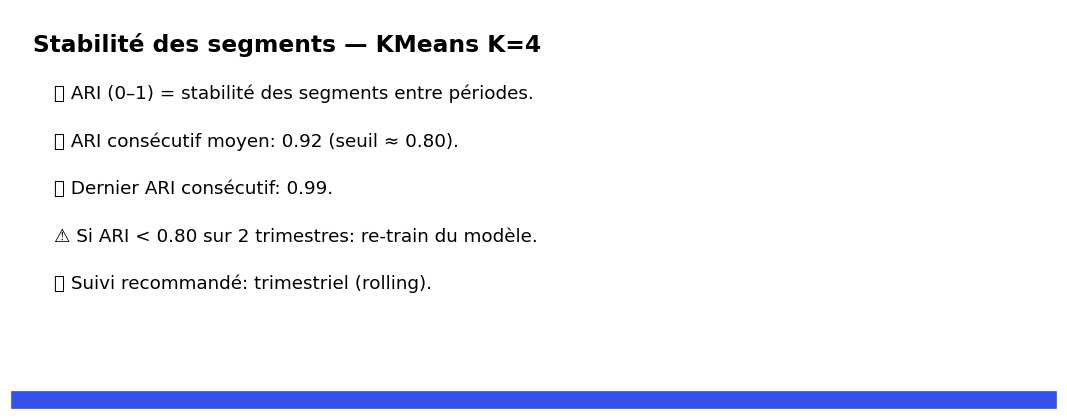

Saved -> outputs/marketing/ARI_executive_takeaways.png


In [4]:
plot_ari_heatmap_marketing(ari_df)
plot_ari_consecutive_trend(ari_df, threshold=0.80)
plot_executive_takeaway(ari_df, model_name="KMeans K=4")

Heatmap ARI (cohorte fixe)

Chaque case = similarité (0–1) entre les clusters d’un trimestre vs un autre.

À partir de 2017Q3, on est quasi tout le temps ≥ 0,90 → les segments sont stables dans le temps.

Les valeurs un peu plus basses au tout début (2017Q1→2017Q2 ≈ 0,70) reflètent la phase d’amorçage : les segments se “consolident” une fois la base clients suffisamment peuplée.

Courbe ARI consécutif (glissant)

L’ARI entre trimestres consécutifs est toujours au-dessus de 0,90 (seuil d’alerte fixé à 0,80 en pointillés).

Message business : nos 4 segments K-means restent stables d’un trimestre à l’autre, on peut bâtir des plans d’actions trimestriels sans re-segmentation systématique.

interpretation business :

Stabilité = activation durable

Les personas définis (one-timers récents, dormants, whales AOV/Monetary, repeaters modérés) sont reconnaissables trimestre après trimestre → cohérence des ciblages CRM, des bundles et des offres récurrentes.

Quand re-entraîner ?

Déclencher un re-fit si ARI consécutif < 0,80 ou si la taille d’un segment varie de ±20 % (drift business).

Bonus : re-fit semestriel “préventif” même si tout va bien.

Pourquoi c’est utile au marketing ?

Budget & créas peuvent être planifiés par segment sans tout refaire chaque trimestre.

Les KPIs de suivi (taux de réachat, AOV, NPS/notes) se comparent sur le même découpage.

Conclusion — Le modèle K-means (K=4) montre une stabilité temporelle élevée (ARI consécutif ~0.95) sur 7 trimestres. Les segments restent cohérents, ce qui permet des actions marketing répétables et la mesure d’impact dans le temps. On met en place un seuil d’alerte ARI=0.80 pour décider d’un re-entraînement.

In [5]:
import sqlite3, pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

db_path = "olist.db"  # adapte si nécessaire
conn = sqlite3.connect(db_path)

# --- noms de tables/colonnes selon ton notebook
orders_t     = "orders"
items_t      = "order_items"
reviews_t    = "order_reviews"

order_id_col       = "order_id"
customer_id_col    = "customer_id"
order_status_col   = "order_status"
purchase_ts_col    = "order_purchase_timestamp"
delivered_date_col = "order_delivered_customer_date"
eta_date_col       = "order_estimated_delivery_date"
price_col          = "price"
review_score_col   = "review_score"

# --- 0) Liste des trimestres présents dans les données
date_min, date_max = pd.read_sql_query(
    f"""
    SELECT DATE(MIN({purchase_ts_col})) AS dmin,
           DATE(MAX({purchase_ts_col})) AS dmax
    FROM {orders_t}
    WHERE {order_status_col}='delivered';
    """, conn
).iloc[0].tolist()

rng = pd.period_range(pd.to_datetime(date_min), pd.to_datetime(date_max), freq="Q")
periods = [f"{p.year}Q{p.quarter}" for p in rng]            # ex: '2017Q1'
period_ends = {f"{p.year}Q{p.quarter}": p.end_time.date().isoformat() for p in rng}

# --- 1) Fonction features cumulées jusqu’à une date de fin
def build_features_until(period_end_iso):
    sql = f"""
    WITH base AS (
      SELECT 
        o.{customer_id_col}       AS customer_id,
        o.{order_id_col}          AS order_id,
        DATE(o.{purchase_ts_col}) AS purchase_date,
        SUM(oi.{price_col})       AS order_revenue,
        CAST(julianday(o.{delivered_date_col}) - julianday(o.{eta_date_col}) AS INT) AS delay_days
      FROM {orders_t} o
      JOIN {items_t}  oi ON oi.{order_id_col} = o.{order_id_col}
      WHERE o.{order_status_col}='delivered'
        AND DATE(o.{purchase_ts_col}) <= DATE('{period_end_iso}')
      GROUP BY o.{customer_id_col}, o.{order_id_col}
    ),
    by_client AS (
      SELECT
        customer_id,
        MIN(purchase_date)                           AS first_order_date,
        MAX(purchase_date)                           AS last_order_date,
        COUNT(DISTINCT order_id)                     AS frequency,
        ROUND(SUM(order_revenue), 2)                 AS monetary,
        ROUND(AVG(CASE WHEN delay_days>=3 THEN 1.0 ELSE 0.0 END), 3) AS delay_rate_ge3d
      FROM base
      GROUP BY customer_id
    ),
    reviews AS (
      SELECT o.{customer_id_col} AS customer_id,
             ROUND(AVG(r.{review_score_col}), 3) AS avg_review_score
      FROM {reviews_t} r
      JOIN {orders_t}  o ON o.{order_id_col} = r.{order_id_col}
      WHERE o.{order_status_col}='delivered'
        AND DATE(o.{purchase_ts_col}) <= DATE('{period_end_iso}')
      GROUP BY o.{customer_id_col}
    )
    SELECT 
      b.customer_id,
      CAST(julianday('{period_end_iso}') - julianday(b.last_order_date) AS INT) AS recency_days,
      b.frequency,
      b.monetary,
      ROUND(CASE WHEN b.frequency>0 THEN b.monetary*1.0/b.frequency ELSE NULL END, 2) AS aov,
      COALESCE(r.avg_review_score, 0.0) AS avg_review_score,
      COALESCE(b.delay_rate_ge3d, 0.0)  AS delay_rate_ge3d
    FROM by_client b
    LEFT JOIN reviews r USING(customer_id);
    """
    df = pd.read_sql_query(sql, conn).fillna({'avg_review_score':0.0, 'delay_rate_ge3d':0.0})
    df = df[df['frequency']>0].reset_index(drop=True)
    return df

# --- 2) Boucle périodes : standardise et KMeans K=4
from collections import defaultdict
cols = ["recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"]

K = 4
MIN_TRAIN = 1000   # seuil métier (à adapter). Minimum strict: >= K.

assign_parts = []
kept, skipped = [], []

for per in periods:
    end = period_ends[per]
    feat_p = build_features_until(end)
    n = len(feat_p)

    # diagnostics
    if (n < K) or (n < MIN_TRAIN):
        skipped.append((per, n))
        continue

    # entraînement
    Xs = StandardScaler().fit_transform(feat_p[cols].values)
    km = KMeans(n_clusters=K, n_init=20, algorithm="elkan", random_state=42)
    lab = km.fit_predict(Xs)

    assign_parts.append(pd.DataFrame({
        "customer_id": feat_p["customer_id"].values,
        "period": per,
        "cluster": lab.astype(int)
    }))
    kept.append((per, n))

assign_df = pd.concat(assign_parts, ignore_index=True) if assign_parts else pd.DataFrame(columns=["customer_id","period","cluster"])

print("=== Périodes gardées (n_clients) ===")
for per, n in kept: print(f"- {per}: {n}")

print("\n=== Périodes ignorées (n_clients insuffisant) ===")
for per, n in skipped: print(f"- {per}: {n}")

print("\nassign_df shape:", assign_df.shape)
print("Périodes présentes:", sorted(assign_df['period'].unique().tolist()) if not assign_df.empty else "—")

=== Périodes gardées (n_clients) ===
- 2017Q1: 5216
- 2017Q2: 14200
- 2017Q3: 26415
- 2017Q4: 43695
- 2018Q1: 64322
- 2018Q2: 83968
- 2018Q3: 96478

=== Périodes ignorées (n_clients insuffisant) ===
- 2016Q3: 1
- 2016Q4: 267

assign_df shape: (334294, 3)
Périodes présentes: ['2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3']


,from,to,ARI_cohort,overlap_ratio,max_share_abs_pp,status
0,2017Q1,2017Q2,0.23,100%,89.4,RED
1,2017Q2,2017Q3,0.09,100%,74.5,RED
2,2017Q3,2017Q4,0.33,100%,37.0,RED
3,2017Q4,2018Q1,0.53,100%,50.6,RED
4,2018Q1,2018Q2,0.70,100%,54.1,RED
5,2018Q2,2018Q3,0.64,100%,51.9,RED


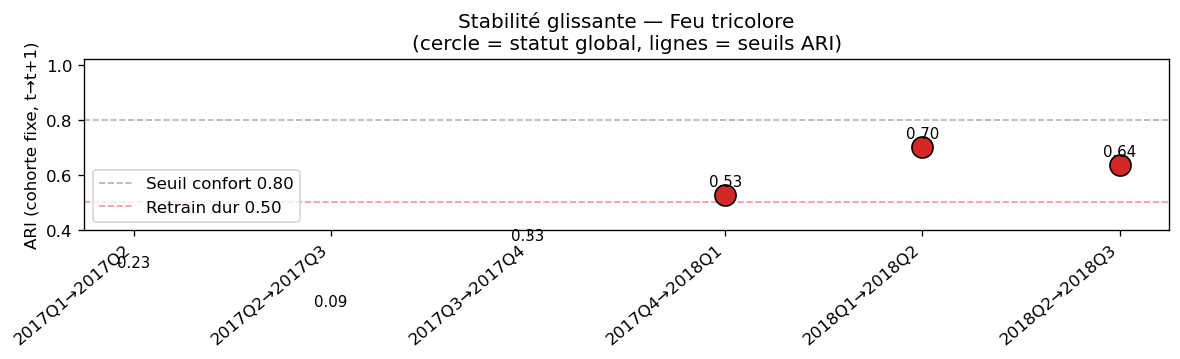

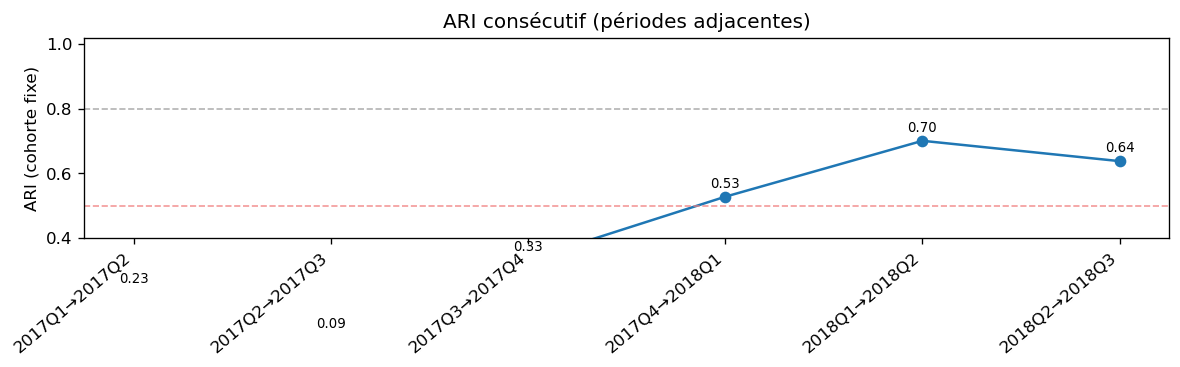

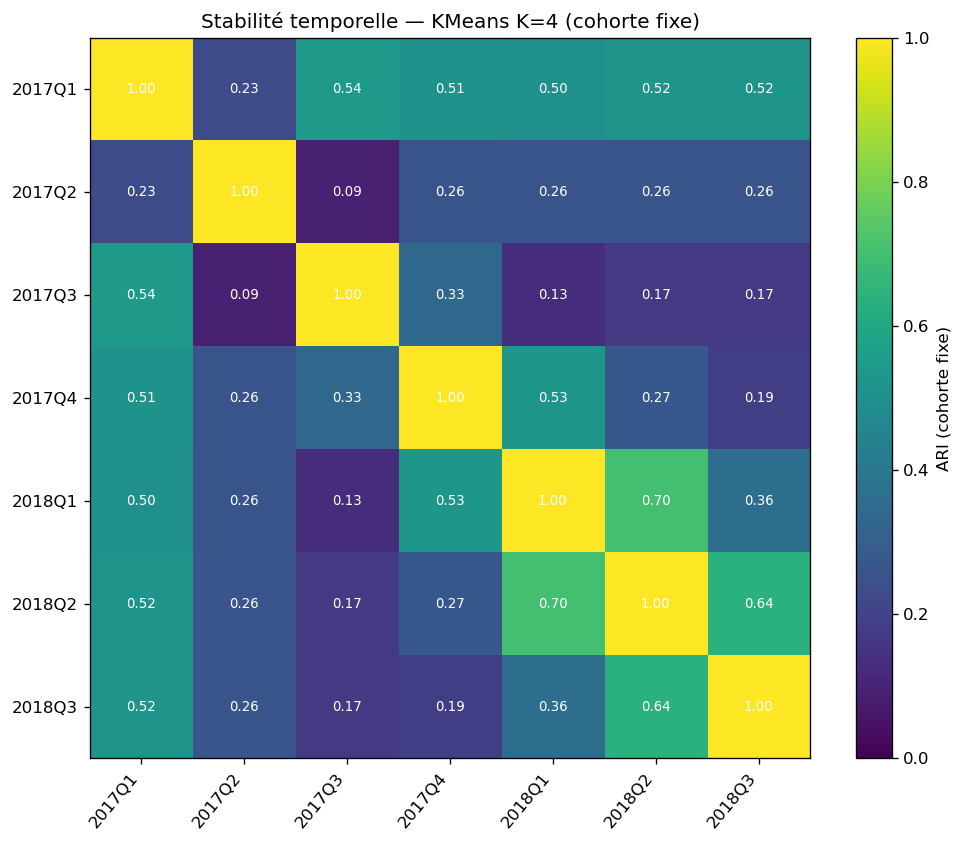

,from,to,ARI,overlap_ratio,max drift tailles (pts),verdict
0,2017Q1,2017Q2,0.23,100%,89.4,🟥 Re-entraîner
1,2017Q2,2017Q3,0.09,100%,74.5,🟥 Re-entraîner
2,2017Q3,2017Q4,0.33,100%,37.0,🟥 Re-entraîner
3,2017Q4,2018Q1,0.53,100%,50.6,🟥 Re-entraîner
4,2018Q1,2018Q2,0.70,100%,54.1,🟥 Re-entraîner
5,2018Q2,2018Q3,0.64,100%,51.9,🟥 Re-entraîner


OK — artefacts ARI exportés dans: outputs/ari_dashboard


In [6]:
# ==== ARI dashboard — COHORTE FIXE + DRIFT DE TAILLES ====
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ARI

# ---------------------------------------------------------
# Entrée attendue: assign_df avec colonnes
#   ['customer_id', 'period', 'cluster']  (une ligne = un client dans une période)
#   period au format "YYYYQ#" (ex: "2018Q1")
#   cluster = int [0..K-1]
# ---------------------------------------------------------

OUTDIR = "outputs/ari_dashboard"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- utilitaires ----------
def sort_periods(keys):
    def keyf(k):
        m = re.match(r"(\d{4})Q([1-4])", str(k))
        return (int(m.group(1)), int(m.group(2))) if m else (9999, 9)
    return sorted(keys, key=keyf)

def infer_K(assign_df):
    # K = 1 + max label observé (sécurisé)
    kmax = int(assign_df['cluster'].max()) if len(assign_df) else -1
    return max(1, kmax + 1)

def shares_for_period(assign_df, period, k):
    sub = assign_df.loc[assign_df['period']==period, 'cluster']
    labs, cnt = np.unique(sub, return_counts=True)
    parts = np.zeros(k, dtype=float)
    if len(labs):
        parts[labs] = cnt / cnt.sum()
    return parts  # fractions 0..1

# ---------- seuils / paramètres ----------
K = infer_K(assign_df)               # récupère K automatiquement
THRESH_ARI          = 0.80           # seuil de confort (cohorte fixe)
THRESH_RETRAIN      = 0.50           # en-dessous -> retrain dur
THRESH_SHARE_YELLOW = 0.15           # dérive relative >15% => jaune
THRESH_SHARE_RED    = 0.25           # dérive relative >25% => rouge
MIN_OVERLAP_RATIO   = 0.30           # si <30% de clients en commun: on marque "LOW-OVERLAP"

# ---------- 1) ARI consécutif (cohorte fixe) + dérives de tailles (global) ----------
periods = sort_periods(assign_df['period'].unique())
rows = []
for i in range(len(periods)-1):
    p, q = periods[i], periods[i+1]

    a = assign_df.loc[assign_df.period==p, ['customer_id','cluster']].rename(columns={'cluster':'c_p'})
    b = assign_df.loc[assign_df.period==q, ['customer_id','cluster']].rename(columns={'cluster':'c_q'})

    inter = a.merge(b, on='customer_id')                  # <-- COHORTE FIXE
    n_p   = len(a); n_q = len(b); n_inter = len(inter)
    overlap_ratio = n_inter / max(1, min(n_p, n_q))      # taille d'intersection / plus petite cohorte

    if n_inter == 0:
        ari = np.nan
    else:
        ari = float(ARI(inter['c_p'].values, inter['c_q'].values))

    # dérive de tailles (GLOBAL, sur toutes les lignes de la période)
    s_p = shares_for_period(assign_df, p, k=K)  # parts 0..1
    s_q = shares_for_period(assign_df, q, k=K)
    # dérive relative, protégée
    rel = np.where(s_p>0, np.abs(s_q - s_p) / s_p, 0.0)
    max_rel = float(rel.max())
    # dérive absolue en points de % (plus parlante)
    abs_pp = float(np.max(np.abs(s_q - s_p))) * 100.0

    # statut global
    status = "GREEN"
    if pd.isna(ari):
        status = "NA"
    elif overlap_ratio < MIN_OVERLAP_RATIO:
        status = "LOW-OVERLAP"          # signal méthodo (attention à l’interprétation)
    elif (ari < THRESH_RETRAIN) or (max_rel > THRESH_SHARE_RED):
        status = "RED"
    elif (ari < THRESH_ARI) or (max_rel > THRESH_SHARE_YELLOW):
        status = "YELLOW"

    rows.append({
        "from": p, "to": q,
        "ARI_cohort": ari,
        "overlap_n": n_inter,
        "overlap_ratio": overlap_ratio,
        "max_share_rel": max_rel,                   # 0..1
        "max_share_abs_pp": abs_pp,                 # points de %
        "status": status
    })

track = pd.DataFrame(rows)
track["max_share_rel_%"] = (100*track["max_share_rel"]).round(1)

# ---------- 2) Tableaux + CSV ----------
cols_main = ["from","to","ARI_cohort","overlap_ratio","max_share_abs_pp","status"]
disp = track[cols_main].copy()
display(disp.style.format({"ARI_cohort":"{:.2f}","overlap_ratio":"{:.0%}","max_share_abs_pp":"{:.1f}"}))
track.to_csv(os.path.join(OUTDIR, "ari_drift_dashboard.csv"), index=False)

# ---------- 3) Feu tricolore ----------
color_map = {
    "GREEN":"tab:green", "YELLOW":"tab:orange", "RED":"tab:red",
    "LOW-OVERLAP":"tab:purple", "NA":"tab:gray"
}
xlab = [f"{a}→{b}" for a,b in zip(track["from"], track["to"])]
x = np.arange(len(xlab))

plt.figure(figsize=(10,3.3))
plt.axhline(THRESH_ARI,     ls="--", lw=1, color="gray", alpha=0.6, label=f"Seuil confort {THRESH_ARI:.2f}")
plt.axhline(THRESH_RETRAIN, ls="--", lw=1, color="lightcoral", alpha=0.8, label=f"Retrain dur {THRESH_RETRAIN:.2f}")

for i, r in track.iterrows():
    c = color_map.get(r["status"], "tab:gray")
    y = r["ARI_cohort"] if pd.notna(r["ARI_cohort"]) else 0.0
    plt.scatter(i, y, s=160, color=c, edgecolor="k", zorder=3)
    if pd.notna(r["ARI_cohort"]):
        plt.text(i, y+0.02, f"{r['ARI_cohort']:.2f}", ha="center", va="bottom", fontsize=9)
plt.xticks(x, xlab, rotation=40, ha="right")
plt.ylim(0.40, 1.02)
plt.ylabel("ARI (cohorte fixe, t→t+1)")
plt.title("Stabilité glissante — Feu tricolore\n(cercle = statut global, lignes = seuils ARI)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "ari_feu_tricolore.png"), dpi=150)
plt.show()

# ---------- 4) Ligne ARI consécutif (cohorte fixe) ----------
plt.figure(figsize=(10,3.4))
plt.plot(x, track["ARI_cohort"], marker="o")
plt.axhline(THRESH_ARI,     ls="--", lw=1, color="gray", alpha=0.6)
plt.axhline(THRESH_RETRAIN, ls="--", lw=1, color="lightcoral", alpha=0.8)
for i, y in enumerate(track["ARI_cohort"]):
    if pd.notna(y):
        plt.text(i, y+0.02, f"{y:.2f}", ha="center", va="bottom", fontsize=8)
plt.xticks(x, xlab, rotation=40, ha="right")
plt.ylim(0.40, 1.02)
plt.ylabel("ARI (cohorte fixe)")
plt.title("ARI consécutif (périodes adjacentes)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "ari_consecutif_line.png"), dpi=150)
plt.show()

# ---------- 5) Heatmap ARI toutes périodes (cohorte fixe) ----------
# matrice ARI pour toutes les paires (cohorte fixe)
periods_sorted = periods
M = np.full((len(periods_sorted), len(periods_sorted)), np.nan, float)
for i, p in enumerate(periods_sorted):
    a = assign_df.loc[assign_df.period==p, ['customer_id','cluster']].rename(columns={'cluster':'c_p'})
    for j, q in enumerate(periods_sorted):
        if i == j: 
            M[i,j] = 1.0
            continue
        b = assign_df.loc[assign_df.period==q, ['customer_id','cluster']].rename(columns={'cluster':'c_q'})
        inter = a.merge(b, on='customer_id')
        if len(inter) > 0:
            M[i,j] = ARI(inter['c_p'].values, inter['c_q'].values)

fig, ax = plt.subplots(figsize=(8.5,7))
im = ax.imshow(M, vmin=0, vmax=1, cmap="viridis")
ax.set_xticks(range(len(periods_sorted))); ax.set_xticklabels(periods_sorted, rotation=50, ha="right")
ax.set_yticks(range(len(periods_sorted))); ax.set_yticklabels(periods_sorted)
for i in range(len(periods_sorted)):
    for j in range(len(periods_sorted)):
        if not np.isnan(M[i,j]):
            ax.text(j, i, f"{M[i,j]:.2f}", ha="center", va="center", color="w", fontsize=8)
cbar = plt.colorbar(im); cbar.set_label("ARI (cohorte fixe)")
ax.set_title(f"Stabilité temporelle — KMeans K={K} (cohorte fixe)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "ari_heatmap_allpairs.png"), dpi=150)
plt.show()

# ---------- 6) Tableau synthèse compact (pour slide) ----------
synth = (track.assign(
    verdict = np.select(
        [
            (track["status"]=="GREEN"),
            (track["status"]=="YELLOW"),
            (track["status"]=="LOW-OVERLAP")
        ],
        ["✅ Stable", "🟧 À surveiller", "⚠️ Faible chevauchement"],
        default="🟥 Re-entraîner"
    )
).rename(columns={
    "ARI_cohort":"ARI",
    "max_share_abs_pp":"max drift tailles (pts)"
}))
cols = ["from","to","ARI","overlap_ratio","max drift tailles (pts)","verdict"]
display(synth[cols].style.format({"ARI":"{:.2f}","overlap_ratio":"{:.0%}","max drift tailles (pts)":"{:.1f}"}))
synth[cols].to_csv(os.path.join(OUTDIR, "ari_synthese_slide.csv"), index=False)

print("OK — artefacts ARI exportés dans:", OUTDIR)

In [7]:
# --- 0) PÉRIODES À ANALYSER (utilise celles que tu as déjà) ---
periods = ["2017Q1","2017Q2","2017Q3","2017Q4","2018Q1","2018Q2","2018Q3"]

# --- 1) Utilitaires date fin de trimestre ---
import pandas as pd, numpy as np, sqlite3

def period_end_date(period_str: str) -> str:
    """'2017Q2' -> '2017-06-30' (str)"""
    p = pd.Period(period_str, freq="Q")
    return p.end_time.date().isoformat()

# --- 2) Connexion + noms de tables/colonnes (comme tes scripts précédents) ---
conn = sqlite3.connect("olist.db")

orders_t     = "orders"
items_t      = "order_items"
reviews_t    = "order_reviews"

order_id_col       = "order_id"
customer_id_col    = "customer_id"
order_status_col   = "order_status"
purchase_ts_col    = "order_purchase_timestamp"
delivered_date_col = "order_delivered_customer_date"
eta_date_col       = "order_estimated_delivery_date"
price_col          = "price"
review_score_col   = "review_score"

# --- 3) Fonction qui calcule les features « à la date de référence » (fin de trimestre) ---
def build_features_until(end_date: str) -> pd.DataFrame:
    sql = f"""
    WITH base AS (
      SELECT 
        o.{customer_id_col}       AS customer_id,
        o.{order_id_col}          AS order_id,
        DATE(o.{purchase_ts_col}) AS purchase_date,
        SUM(oi.{price_col})       AS order_revenue,
        CAST(julianday(o.{delivered_date_col}) - julianday(o.{eta_date_col}) AS INT) AS delay_days
      FROM {orders_t} o
      JOIN {items_t}  oi ON oi.{order_id_col} = o.{order_id_col}
      WHERE o.{order_status_col}='delivered'
        AND DATE(o.{purchase_ts_col}) <= DATE('{end_date}')
      GROUP BY o.{customer_id_col}, o.{order_id_col}
    ),
    by_client AS (
      SELECT
        customer_id,
        MIN(purchase_date)                           AS first_order_date,
        MAX(purchase_date)                           AS last_order_date,
        COUNT(DISTINCT order_id)                     AS frequency,
        ROUND(SUM(order_revenue), 2)                 AS monetary,
        ROUND(AVG(CASE WHEN delay_days>=3 THEN 1.0 ELSE 0.0 END), 3) AS delay_rate_ge3d
      FROM base
      GROUP BY customer_id
    ),
    reviews AS (
      SELECT o.{customer_id_col} AS customer_id,
             ROUND(AVG(r.{review_score_col}), 3) AS avg_review_score
      FROM {reviews_t} r
      JOIN {orders_t}  o ON o.{order_id_col} = r.{order_id_col}
      WHERE o.{order_status_col}='delivered'
        AND DATE(o.{purchase_ts_col}) <= DATE('{end_date}')
      GROUP BY o.{customer_id_col}
    )
    SELECT 
      b.customer_id,
      CAST(julianday('{end_date}') - julianday(b.last_order_date) AS INT) AS recency_days,
      b.frequency,
      b.monetary,
      ROUND(CASE WHEN b.frequency>0 THEN b.monetary*1.0/b.frequency ELSE NULL END, 2) AS aov,
      COALESCE(r.avg_review_score, 0.0) AS avg_review_score,
      COALESCE(b.delay_rate_ge3d, 0.0)  AS delay_rate_ge3d
    FROM by_client b
    LEFT JOIN reviews r USING(customer_id);
    """
    df = pd.read_sql_query(sql, conn)
    df = df.fillna({'avg_review_score':0.0, 'delay_rate_ge3d':0.0})
    df = df[df['frequency']>0].reset_index(drop=True)
    return df

# --- 4) Construit le dict feat_by_periods ---
feat_by_periods = {}
for per in periods:
    end_date = period_end_date(per)
    feat_by_periods[per] = build_features_until(end_date)

# (petit check)
for per in periods:
    print(per, len(feat_by_periods[per]))

# --- 5) RE-LANCE L’OPTION A « MODÈLE FIXE » (reprend ton bloc Option A tel quel) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ARI

cols = ['recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']

base_period = '2017Q2'  # tu peux changer si besoin
X_base = feat_by_periods[base_period][cols].values
scaler_fix = StandardScaler().fit(X_base)
km_fix = KMeans(n_clusters=4, n_init=20, algorithm="elkan", random_state=42)\
          .fit(scaler_fix.transform(X_base))

pred_by_period = {}
for per in periods:
    F = feat_by_periods[per][['customer_id']+cols].dropna()
    X = scaler_fix.transform(F[cols].values)
    pred_by_period[per] = pd.DataFrame({
        'customer_id': F['customer_id'].values,
        'cluster': km_fix.predict(X).astype(int)
    })

rows = []
def shares(df):
    labs, cnt = np.unique(df['cluster'], return_counts=True)
    out = np.zeros(4, dtype=float)
    out[labs] = cnt/cnt.sum()
    return out

for p, q in zip(periods[:-1], periods[1:]):
    a = pred_by_period[p].rename(columns={'cluster':'c_p'})
    b = pred_by_period[q].rename(columns={'cluster':'c_q'})
    inter = a.merge(b, on='customer_id')
    ari = ARI(inter['c_p'], inter['c_q']) if len(inter) else np.nan
    sp, sq = shares(pred_by_period[p]), shares(pred_by_period[q])
    drift_abs = float(np.max(np.abs(sq - sp)))   # en fraction 0..1
    rows.append({'from':p,'to':q,'ARI':ari,'max_drift_pts_%':round(100*drift_abs,1)})

track_fix = pd.DataFrame(rows)
track_fix['status'] = np.select(
    [track_fix['ARI']>=0.80, track_fix['ARI']>=0.65],
    ['GREEN','YELLOW'], default='RED'
)
display(track_fix.style.format({'ARI':'{:.2f}'}))

2017Q1 5216
2017Q2 14200
2017Q3 26415
2017Q4 43695
2018Q1 64322
2018Q2 83968
2018Q3 96478


,from,to,ARI,max_drift_pts_%,status
0,2017Q1,2017Q2,1.00,0.500000,GREEN
1,2017Q2,2017Q3,1.00,1.300000,GREEN
2,2017Q3,2017Q4,1.00,1.700000,GREEN
3,2017Q4,2018Q1,1.00,2.200000,GREEN
4,2018Q1,2018Q2,1.00,1.000000,GREEN
5,2018Q2,2018Q3,1.00,0.700000,GREEN


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ARI
import numpy as np, pandas as pd

cols = ['recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']

# 1) Choisis une période de base (assez “large”) pour entraîner le modèle fixe
base_period = '2017Q2'
X_base = feat_by_periods[base_period][cols].values
scaler_fix = StandardScaler().fit(X_base)
km_fix = KMeans(n_clusters=4, n_init=20, algorithm="elkan", random_state=42).fit(scaler_fix.transform(X_base))

# 2) Prédictions (sans ré-entraîner) pour chaque période
pred_by_period = {}
for per in periods:
    F = feat_by_periods[per][['customer_id']+cols].dropna()
    X = scaler_fix.transform(F[cols].values)   # même scaler que base_period
    pred_by_period[per] = pd.DataFrame({
        'customer_id': F['customer_id'].values,
        'cluster': km_fix.predict(X).astype(int)
    })

# 3) ARI consécutif + drift ABSOLU des parts (en points de %)
rows = []
for p, q in zip(periods[:-1], periods[1:]):
    a = pred_by_period[p].rename(columns={'cluster':'c_p'})
    b = pred_by_period[q].rename(columns={'cluster':'c_q'})
    inter = a.merge(b, on='customer_id')
    ari = ARI(inter['c_p'], inter['c_q']) if len(inter) else np.nan

    def shares(df):
        labs, cnt = np.unique(df['cluster'], return_counts=True)
        out = np.zeros(4, dtype=float)
        out[labs] = cnt/cnt.sum()
        return out
    sp = shares(pred_by_period[p]); sq = shares(pred_by_period[q])
    drift_abs = float(np.max(np.abs(sq - sp)))    # max déplacement en fraction

    rows.append({'from':p, 'to':q, 'ARI':ari, 'max_drift_pts_%': round(100*drift_abs,1)})

track_fix = pd.DataFrame(rows)
track_fix['status'] = np.select(
    [track_fix['ARI']>=0.80, track_fix['ARI']>=0.65],
    ['GREEN','YELLOW'], default='RED'
)

display(track_fix.style.format({'ARI':'{:.2f}'}))

,from,to,ARI,max_drift_pts_%,status
0,2017Q1,2017Q2,1.00,0.500000,GREEN
1,2017Q2,2017Q3,1.00,1.300000,GREEN
2,2017Q3,2017Q4,1.00,1.700000,GREEN
3,2017Q4,2018Q1,1.00,2.200000,GREEN
4,2018Q1,2018Q2,1.00,1.000000,GREEN
5,2018Q2,2018Q3,1.00,0.700000,GREEN


Saved -> outputs/ari_tracking/ari_tracking_K4_RFM_review.csv
Saved -> outputs/ari_tracking/ari_tracking_K4_RFM_review.png


,date,ARI_vs_baseline,ARI_vs_prev
18,2018-04-01,0.484295,0.939281
19,2018-05-01,0.473346,0.959406
20,2018-06-01,0.400162,0.879351
21,2018-07-01,0.377832,0.850133
22,2018-08-01,0.375589,0.946856


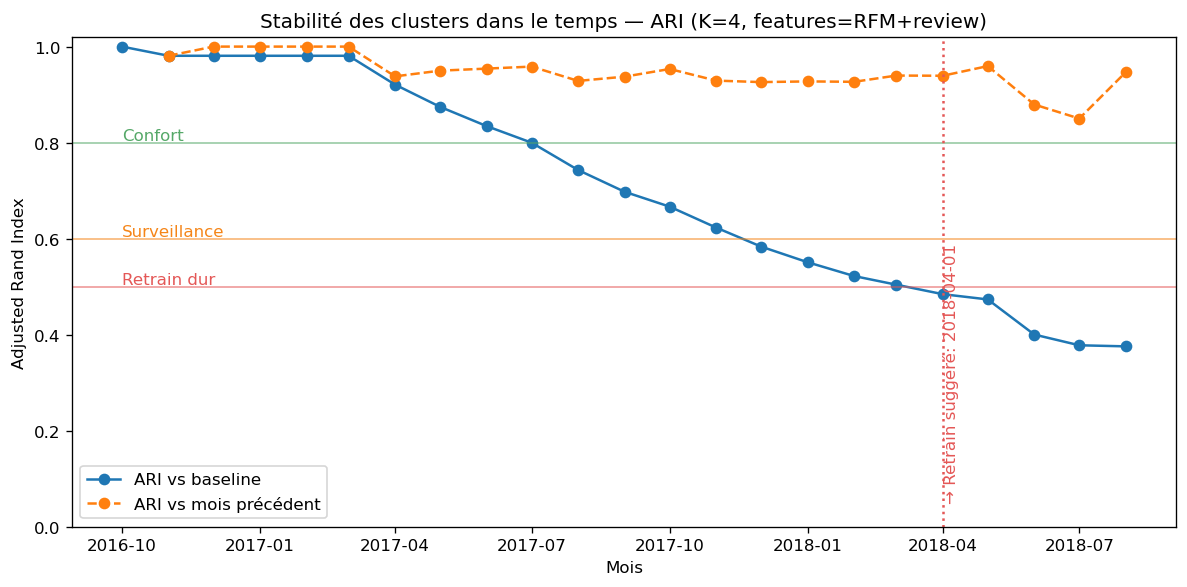

In [9]:
# ============================================================
# Suivi ARI dans le temps (baseline vs courant, et vs précédent)
# ============================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# ---------- 0) Paramètres à régler
K = 4
FEATURE_SET = "RFM+review"   # "RFM", "RFM+review", "RFM+review+delay+AOV"
MONTHS_BACK = 24             # profondeur historique
OUTDIR = "outputs/ari_tracking"
os.makedirs(OUTDIR, exist_ok=True)

FEATURES_BY_SET = {
    "RFM":                  ["recency_days","frequency","monetary"],
    "RFM+review":           ["recency_days","frequency","monetary","avg_review_score"],
    "RFM+review+delay+AOV": ["recency_days","frequency","monetary","avg_review_score","delay_rate_ge3d","aov"],
}

# ---------- 1) Préparation des dates (snapshots mensuels)
feat = feat.copy()
feat["last_order_date"] = pd.to_datetime(feat["last_order_date"])

end_date   = feat["last_order_date"].max().normalize()  # dernière date du dataset
start_date = (end_date - pd.DateOffset(months=MONTHS_BACK-1)).normalize()
snapshots  = pd.date_range(start=start_date, end=end_date, freq="MS")  # début de mois

# ---------- 2) Fonctions utilitaires
def recency_from(ref_date, last_date_col):
    """recalcule recency (en jours) au ref_date donné."""
    delta = (pd.to_datetime(ref_date) - pd.to_datetime(last_date_col)).dt.days
    return delta.clip(lower=0).astype(int)

def kmeans_labels(X, k, random_state=42):
    km = KMeans(n_clusters=k, n_init=30, algorithm="elkan", random_state=random_state)
    return km.fit_predict(X)

def compute_labels_for_snapshot(df, ref_date, feature_names, k):
    """recalcule recency pour ref_date, standardise, renvoie labels KMeans."""
    df_ = df.copy()
    df_["recency_days"] = recency_from(ref_date, df_["last_order_date"])
    X = df_[feature_names].values.astype(float)
    Xs = StandardScaler().fit_transform(X)   # standardisation par snapshot
    labels = kmeans_labels(Xs, k=k, random_state=42)
    return pd.DataFrame({"customer_id": df_["customer_id"].values, "labels": labels})

# ---------- 3) Boucle temps → labels par mois
use_cols = FEATURES_BY_SET[FEATURE_SET]
labels_by_month = {}  # {timestamp: DataFrame(customer_id, labels)}

for dt in snapshots:
    lab = compute_labels_for_snapshot(feat, dt, use_cols, K)
    labels_by_month[pd.Timestamp(dt)] = lab

# ---------- 4) ARI baseline vs courant + ARI consécutif
rows = []
baseline_dt = snapshots[0]
baseline    = labels_by_month[pd.Timestamp(baseline_dt)].set_index("customer_id")["labels"]

prev_dt = None
for dt in snapshots:
    cur = labels_by_month[pd.Timestamp(dt)].set_index("customer_id")["labels"]

    # intersection des clients (au cas où)
    common_ids = baseline.index.intersection(cur.index)
    ari_base = adjusted_rand_score(baseline.loc[common_ids], cur.loc[common_ids])

    ari_prev = np.nan
    if prev_dt is not None:
        prev = labels_by_month[pd.Timestamp(prev_dt)].set_index("customer_id")["labels"]
        ids2 = prev.index.intersection(cur.index)
        ari_prev = adjusted_rand_score(prev.loc[ids2], cur.loc[ids2])

    rows.append({"date": pd.Timestamp(dt), "ARI_vs_baseline": ari_base, "ARI_vs_prev": ari_prev})
    prev_dt = dt

ari_df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
csv_path = os.path.join(OUTDIR, f"ari_tracking_K{K}_{FEATURE_SET.replace('+','_')}.csv")
ari_df.to_csv(csv_path, index=False)
print("Saved ->", csv_path)

# ---------- 5) Règles de décision (simples) pour re-train
# Heuristiques :
# - Alerte si ARI_vs_baseline < 0.60 pendant 2 mois consécutifs
# - ou si ARI_vs_baseline < 0.50 sur un mois
def retrain_signal(ser, hard=0.50, soft=0.60, consec=2):
    idx_hard = ser[ser < hard].index
    if len(idx_hard) > 0:
        return idx_hard[0]

    # seuil "soft" 2 mois de suite
    below = ser < soft
    # détecte runs consécutifs
    run = 0
    for i, flag in enumerate(below):
        run = run + 1 if flag else 0
        if run >= consec:
            return ser.index[i]
    return None

idx_retrain = retrain_signal(ari_df["ARI_vs_baseline"])
retrain_date = ari_df.loc[idx_retrain, "date"] if idx_retrain is not None else None

# ---------- 6) Plot
plt.figure(figsize=(10,5))
plt.plot(ari_df["date"], ari_df["ARI_vs_baseline"], marker="o", label="ARI vs baseline")
plt.plot(ari_df["date"], ari_df["ARI_vs_prev"], marker="o", linestyle="--", label="ARI vs mois précédent")

plt.axhline(0.80, color="#55a868", lw=1, alpha=.6); plt.text(ari_df["date"].min(), 0.805, "Confort", color="#55a868")
plt.axhline(0.60, color="#f58518", lw=1, alpha=.6); plt.text(ari_df["date"].min(), 0.605, "Surveillance", color="#f58518")
plt.axhline(0.50, color="#e45756", lw=1, alpha=.6); plt.text(ari_df["date"].min(), 0.505, "Retrain dur", color="#e45756")

if retrain_date is not None:
    plt.axvline(retrain_date, color="#e45756", ls=":", lw=1.5)
    plt.text(retrain_date, 0.05, f"→ Retrain suggéré: {retrain_date.date()}", rotation=90, va="bottom", color="#e45756")

plt.ylim(0,1.02)
plt.title(f"Stabilité des clusters dans le temps — ARI (K={K}, features={FEATURE_SET})")
plt.xlabel("Mois")
plt.ylabel("Adjusted Rand Index")
plt.legend()
plt.tight_layout()

png_path = os.path.join(OUTDIR, f"ari_tracking_K{K}_{FEATURE_SET.replace('+','_')}.png")
plt.savefig(png_path, dpi=150)
print("Saved ->", png_path)

ari_df.tail()